In [2]:
import datetime

from src.logger import LoggerConfig

LoggerConfig.setup_logger()

ANALYSIS_START_DATE = datetime.date.fromisoformat("2014-09-17")
ANALYSIS_END_DATE = datetime.date.fromisoformat("2025-04-27")

2025-04-28 19:10:26,506 - root - INFO - Logger configured


In [3]:
from src.data_sources.google_trends import GoogleTrendsDataSource
google_trends_data = GoogleTrendsDataSource.load(
    from_date=ANALYSIS_START_DATE,
    to_date=ANALYSIS_END_DATE,
    keywords=[
        'bitcoin', 'btc', 'ethereum', 'eth', 'crypto',
        'buy bitcoin', 'sell bitcoin', 'bitcoin price', 'crypto trading', 'crypto price',
        'crypto crash', 'bitcoin crash', 'crypto fear', 'crypto bull run', 'crypto bear market',
        'gold', 'usd', 'usdt', 'usdc',
        'web3', 'nft', 'defi', 'blockchain',
        'binance', 'coinbase', 'crypto.com', 'kraken', 'okx',
        'bitcoin investment', 'how to buy bitcoin', 'bitcoin price',
        'war', 'conflict', 'ETF',
    ]
)
google_trends_data

2025-04-28 19:10:27,533 - root - INFO - Загружаем данные из API
2025-04-28 19:10:27,874 - root - INFO - Собираем тренды для: ['bitcoin', 'btc', 'ethereum', 'eth', 'crypto']


TooManyRequestsError: The request failed: Google returned a response with code 429

In [4]:
from src.data_sources.prices import PricesDataSource
prices_data = PricesDataSource.load(
    from_date=ANALYSIS_START_DATE,
    to_date=ANALYSIS_END_DATE,
    tickers=[
        'BTC-USD',
        'ETH-USD',
    ]
)
prices_data

,date,Close,Close.1,High,High.1,Low,Low.1,Open,Open.1,Volume,Volume.1
0,date,BTC-USD,ETH-USD,BTC-USD,ETH-USD,BTC-USD,ETH-USD,BTC-USD,ETH-USD,BTC-USD,ETH-USD
1,2014-09-17,457.3340148925781,NaN,468.17401123046875,NaN,452.4219970703125,NaN,465.864013671875,NaN,21056800,NaN
2,2014-09-18,424.44000244140625,NaN,456.8599853515625,NaN,413.10400390625,NaN,456.8599853515625,NaN,34483200,NaN
3,2014-09-19,394.7959899902344,NaN,427.8349914550781,NaN,384.5320129394531,NaN,424.1029968261719,NaN,37919700,NaN
4,2014-09-20,408.90399169921875,NaN,423.2959899902344,NaN,389.88299560546875,NaN,394.6730041503906,NaN,36863600,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3871,2025-04-22,93441.890625,1757.3316650390625,93817.3828125,1773.63916015625,87084.53125,1542.0003662109375,87521.875,1579.815185546875,55899038456,23747917555.0
3872,2025-04-23,93699.109375,1796.104248046875,94535.734375,1829.7099609375,91962.9609375,1746.924072265625,93427.5859375,1757.196533203125,41719568821,22904644756.0
3873,2025-04-24,93943.796875,1769.8316650390625,94016.1953125,1801.69140625,91696.7109375,1724.74072265625,93692.3984375,1795.9794921875,31483175315,15207402759.0
3874,2025-04-25,94720.5,1786.634521484375,95768.390625,1826.696044921875,92898.59375,1740.3319091796875,93954.25,1770.003662109375,40915232364,17459399281.0


In [33]:
imporst pandas as pd
import numpy as np
import ta  # если не установлено: pip install ta

# --- 1. Препроцессинг BTC данных ---
btc = btc_usd_price_data.copy()
btc['date'] = pd.to_datetime(btc['date'])
btc = btc.sort_values('date')

# --- 2. Препроцессинг Google Trends ---
trends = google_trends_data.copy()
trends['date'] = pd.to_datetime(trends['date'])
trends = trends.sort_values('date')

# Заполняем отсутствующие даты "последним известным значением"
full_dates = pd.DataFrame({'date': pd.date_range(btc['date'].min(), btc['date'].max(), freq='D')})
trends = pd.merge(full_dates, trends, on='date', how='left')
trends[['crypto', 'bitcoin']] = trends[['crypto', 'bitcoin']].ffill().bfill()

# --- 3. Объединение данных ---
df = pd.merge(btc, trends, on='date', how='left')

# --- 4. Генерация технических индикаторов ---
# 4.1 Скользящие средние
df['ma_5'] = df['close'].rolling(window=5, min_periods=1).mean()
df['ma_10'] = df['close'].rolling(window=10, min_periods=1).mean()

# 4.2 Индикатор RSI
rsi_indicator = ta.momentum.RSIIndicator(close=df['close'], window=6)
df['rsi_6'] = rsi_indicator.rsi()
rsi_indicator = ta.momentum.RSIIndicator(close=df['close'], window=12)
df['rsi_12'] = rsi_indicator.rsi()
rsi_indicator = ta.momentum.RSIIndicator(close=df['close'], window=24)
df['rsi_24'] = rsi_indicator.rsi()

# 4.3 Волатильность
df['volatility_6'] = df['close'].rolling(window=6, min_periods=1).std()
df['volatility_12'] = df['close'].rolling(window=12, min_periods=1).std()
df['volatility_24'] = df['close'].rolling(window=24, min_periods=1).std()

# 4.4 Процентное изменение цены
df['price_change_1d'] = df['close'].pct_change(periods=1)
df['price_change_7d'] = df['close'].pct_change(periods=7)
df['price_change_30d'] = df['close'].pct_change(periods=30)

df['price_v'] = df['high'] - df['low']
df['price_v2'] = df['open'] - df['close']

# 4.5 MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd_line'] = ema_12 - ema_26
df['macd_signal'] = df['macd_line'].ewm(span=9, adjust=False).mean()

# --- 5. Создание целевых переменных (target'ов) ---
df['target_1d'] = df['close'].shift(-1)
df['target_7d'] = df['close'].shift(-7)
df['target_30d'] = df['close'].shift(-30)

# --- 6. Генерация лагов ---
lag_features = [
    'open', 'high', 'low', 'close', 'volume',
    'ma_5', 'ma_10',
    'rsi_6', 'rsi_12', 'rsi_24',
    'volatility_6', 'volatility_12', 'volatility_24',
    'price_change_1d', 'price_change_7d', 'price_change_30d'
]

lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 56, 112, 224]

for feature in lag_features:
    for lag in lags:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# --- 7. Финальная подготовка ---
# Убираем строки с пустыми значениями
df = df.dropna(subset=['target_1d', 'target_7d', 'target_30d'])

# --- 8. Отделяем фичи и таргеты ---
# Теперь все колонки кроме target-ов и даты — это признаки
target_columns = ['target_1d', 'target_7d', 'target_30d']
exclude_columns = ['date', 'target_1d', 'target_7d', 'target_30d']
feature_columns = [col for col in df.columns if col not in exclude_columns]

features = df[feature_columns]
targets = df[target_columns]


C:\Users\nurla\AppData\Local\Temp\ipykernel_19144\2644766222.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\nurla\AppData\Local\Temp\ipykernel_19144\2644766222.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\nurla\AppData\Local\Temp\ipykernel_19144\2644766222.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [29]:
df

,date,close,high,low,open,volume,crypto,bitcoin,ma_5,ma_10,...,volume_lag_21,volume_lag_22,volume_lag_23,volume_lag_24,volume_lag_25,volume_lag_26,volume_lag_27,volume_lag_28,volume_lag_29,volume_lag_30
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,0.0,3.0,457.334015,457.334015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,0.0,3.0,440.887009,440.887009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,0.0,3.0,425.523336,425.523336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,0.0,3.0,421.368500,421.368500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,0.0,3.0,416.859003,416.859003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3863,2025-04-15,83668.992188,86429.351562,83598.820312,84539.695312,28040322885,9.0,23.0,84117.660937,81651.017187,...,3.000584e+10,3.458260e+10,1.259462e+10,9.863214e+09,1.903045e+10,2.902899e+10,3.493196e+10,2.409577e+10,2.509279e+10,2.133027e+10
3864,2025-04-16,84033.867188,85428.281250,83100.617188,83674.507812,29617804112,9.0,23.0,84243.467188,82232.955469,...,2.670405e+10,3.000584e+10,3.458260e+10,1.259462e+10,9.863214e+09,1.903045e+10,2.902899e+10,3.493196e+10,2.409577e+10,2.509279e+10
3865,2025-04-17,84895.750000,85449.070312,83749.750000,84030.671875,21276866029,9.0,23.0,84165.195312,82798.996875,...,2.441347e+10,2.670405e+10,3.000584e+10,3.458260e+10,1.259462e+10,9.863214e+09,1.903045e+10,2.902899e+10,3.493196e+10,2.409577e+10
3866,2025-04-18,84450.804688,85095.046875,84298.882812,84900.187500,12728372364,9.0,23.0,84318.360937,83616.882031,...,3.419862e+10,2.441347e+10,2.670405e+10,3.000584e+10,3.458260e+10,1.259462e+10,9.863214e+09,1.903045e+10,2.902899e+10,3.493196e+10


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58677
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 259
[LightGBM] [Info] Start training from score 15253.730472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

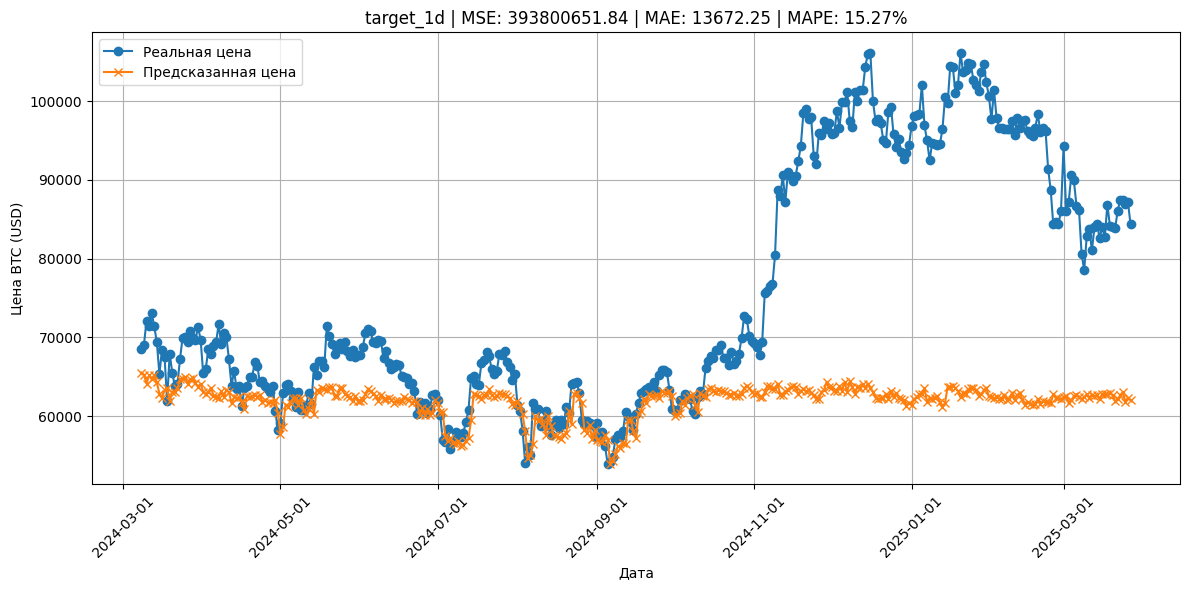

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58677
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 259
[LightGBM] [Info] Start training from score 15376.024997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

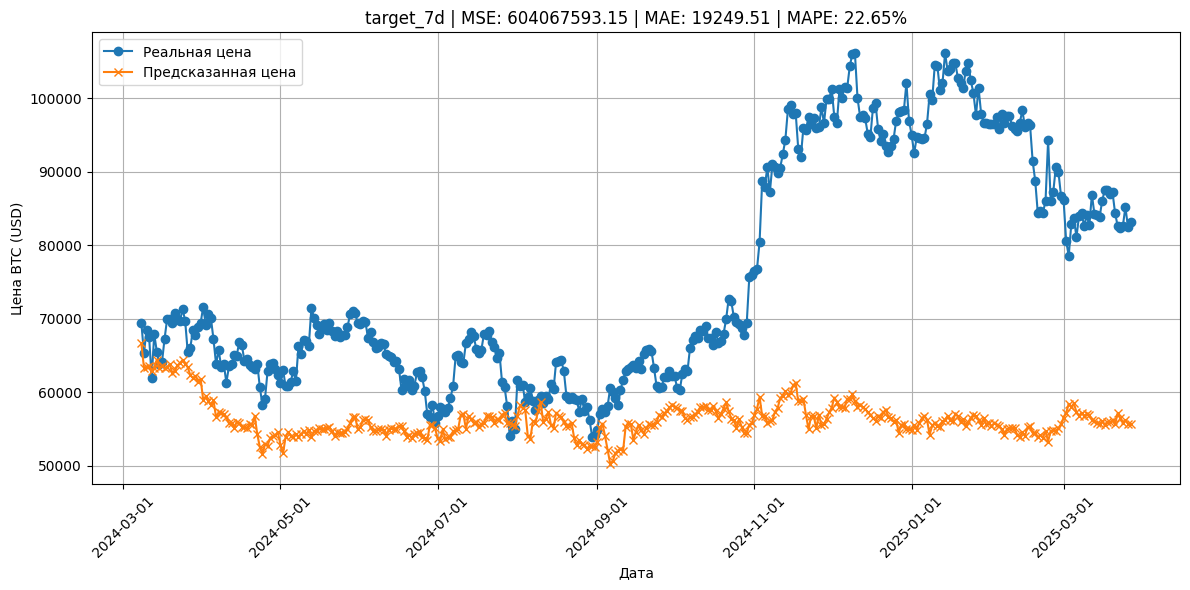

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58677
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 259
[LightGBM] [Info] Start training from score 15823.955977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

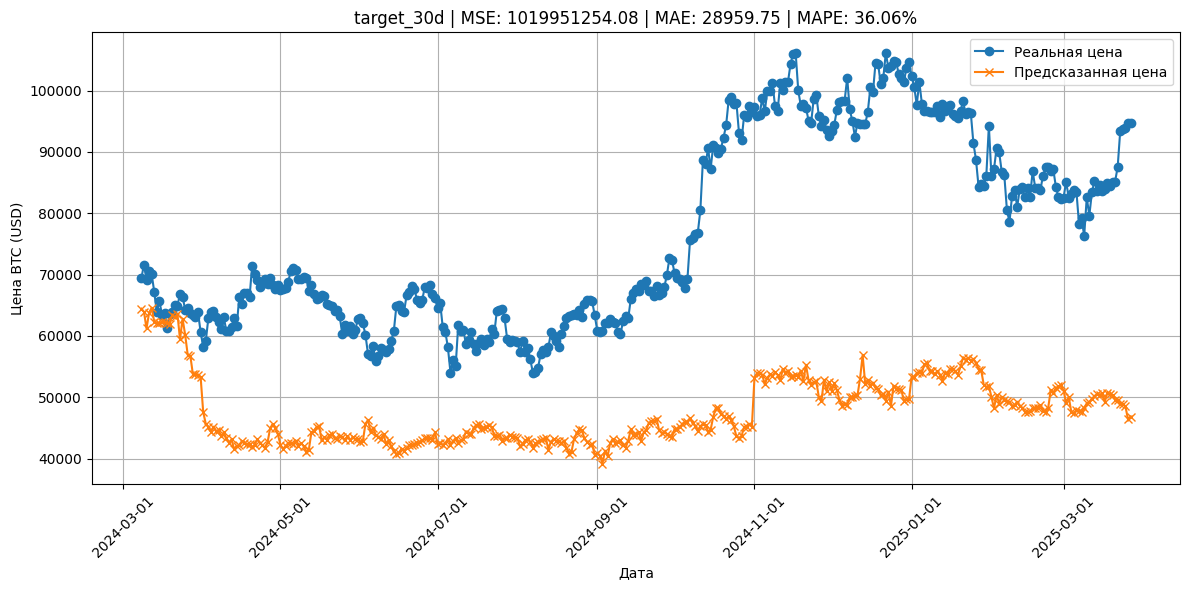

In [46]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

models = {}
mse_scores = {}
mape_scores = {}

# 1. Разделяем данные
X = features.copy()
y = targets.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# 2. Для каждой цели обучаем свою модель
for target_name in y.columns:
    model = LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        # min_child_samples=10,
        # learning_rate=0.05,
        # colsample_bytree=0.5,
        # subsample=0.5,
        # reg_alpha=0.1,
        # reg_lambda=0.1,
    )
    model.fit(X_train, y_train[target_name])

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target_name], y_pred)
    mae = mean_absolute_error(y_test[target_name], y_pred)
    mape = np.mean(np.abs((y_test[target_name] - y_pred) / y_test[target_name])) * 100  # Процентная ошибка

    models[target_name] = model
    mse_scores[target_name] = mse
    mape_scores[target_name] = mape

    # 3. Строим график для каждой цели
    plt.figure(figsize=(12, 6))
    x_dates = df.loc[y_test.index, 'date']

    plt.plot(x_dates, y_test[target_name].values, label="Реальная цена", marker='o')
    plt.plot(x_dates, y_pred, label="Предсказанная цена", marker='x')
    plt.title(f"{target_name} | MSE: {mse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")
    plt.xlabel("Дата")
    plt.ylabel("Цена BTC (USD)")
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

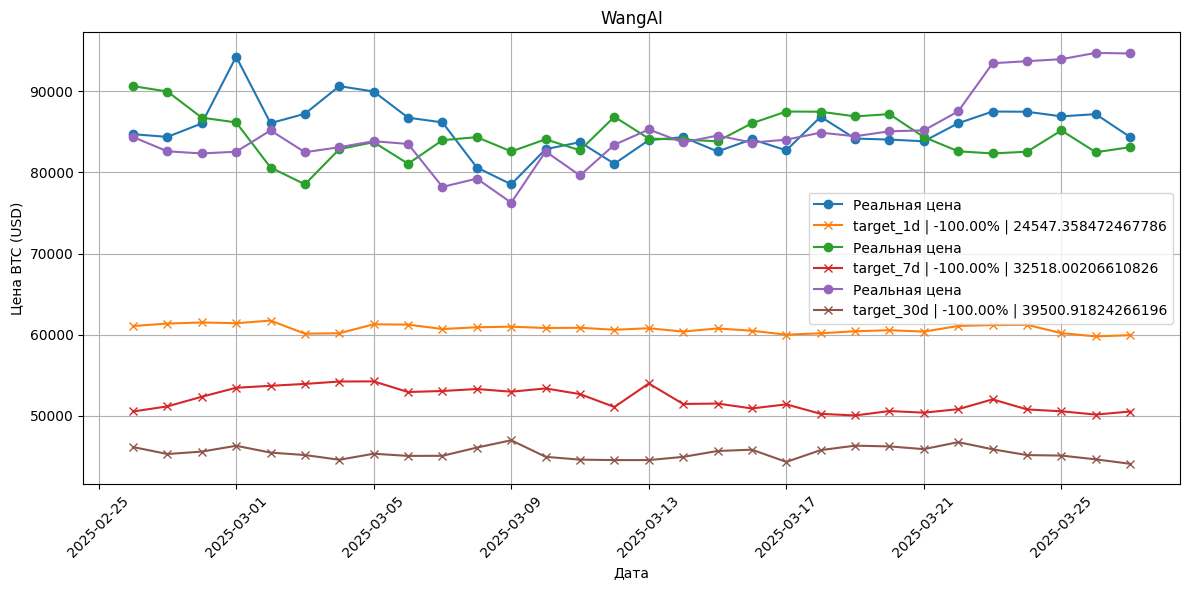

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def predict_price(model_name: str, latest_features) -> float:
    return models[model_name].predict(latest_features)[0]

def predict(model_: str):
    days_to_predict = 30
    real_prices = []
    real_prices_today = []
    predicted_prices = []
    prediction_errors = []
    dates = []

    for i in range(-days_to_predict, 0):
        real_price = float(targets.iloc[i][model_])
        predicted_price = predict_price(model_, features.iloc[[i]])
        real_prices.append(real_price)
        real_prices_today.append(float(targets.iloc[i-1][model_]))
        predicted_prices.append(predicted_price)
        prediction_errors.append(real_price - predicted_price)
        dates.append(df.iloc[targets.index[i]]['date'])

    # --- Средняя ошибка ---
    mean_abs_error = np.mean(np.abs(prediction_errors))

    # --- Симуляция торговли на основе предсказаний ---
    initial_budget = 1000
    budget = initial_budget
    profits = []
    for real, pred, real_d in zip(real_prices, predicted_prices, real_prices_today):
        position = 1 if pred > real_d else -1
        price_change = real - pred
        daily_return = (price_change / pred) * position
        budget *= (1 + daily_return)
        profits.append(daily_return)
    total_return_percent = ((budget - initial_budget) / initial_budget) * 100

    # --- Строим график ---
    plt.plot(dates, real_prices, label="Реальная цена", marker='o')
    plt.plot(dates, predicted_prices, label=f"{model_} | {total_return_percent:.2f}% | {mean_abs_error}", marker='x')

plt.figure(figsize=(12, 6))
predict('target_1d')
predict('target_7d')
predict('target_30d')


plt.title(f"WangAI")
plt.xlabel("Дата")
plt.ylabel("Цена BTC (USD)")
plt.legend()
plt.grid(True)

# Оформление дат
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                   feature  importance
0                    close         142
2                      low          31
1                     high          31
187     volatility_6_lag_7          14
48                price_v2          11
47                 price_v           9
137           ma_10_lag_21           8
31                  kraken           8
180         rsi_24_lag_224           7
220  price_change_1d_lag_1           7
57              open_lag_7           7
211    volatility_24_lag_5           7
112          volume_lag_28           6
182     volatility_6_lag_2           6
190    volatility_6_lag_28           6
38                   rsi_6           6
72             high_lag_21           6
107           volume_lag_5           6
15            crypto crash           6
103           volume_lag_1           6


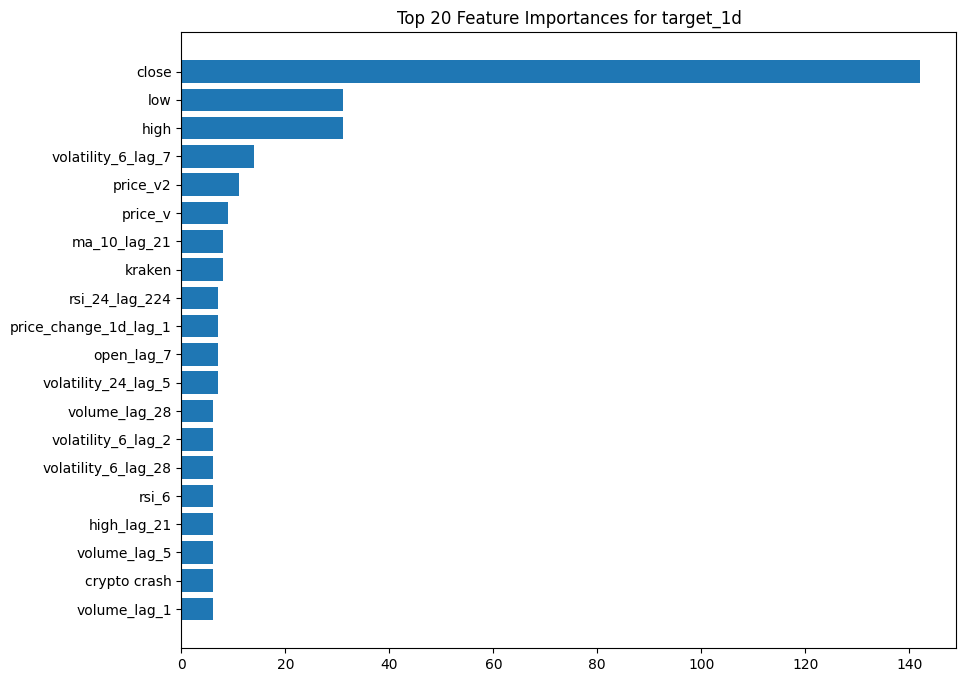

                   feature  importance
0                    close          59
2                      low          19
1                     high          19
15            crypto crash          14
18         crypto bull run          14
219  volatility_24_lag_224          14
217   volatility_24_lag_56          12
216   volatility_24_lag_28          12
50             macd_signal          12
31                  kraken          11
126            ma_5_lag_56          10
20                    gold           9
203   volatility_12_lag_28           9
218  volatility_24_lag_112           9
43           volatility_24           8
46        price_change_30d           8
189    volatility_6_lag_21           7
109           volume_lag_7           6
67              high_lag_4           6
73             high_lag_28           6


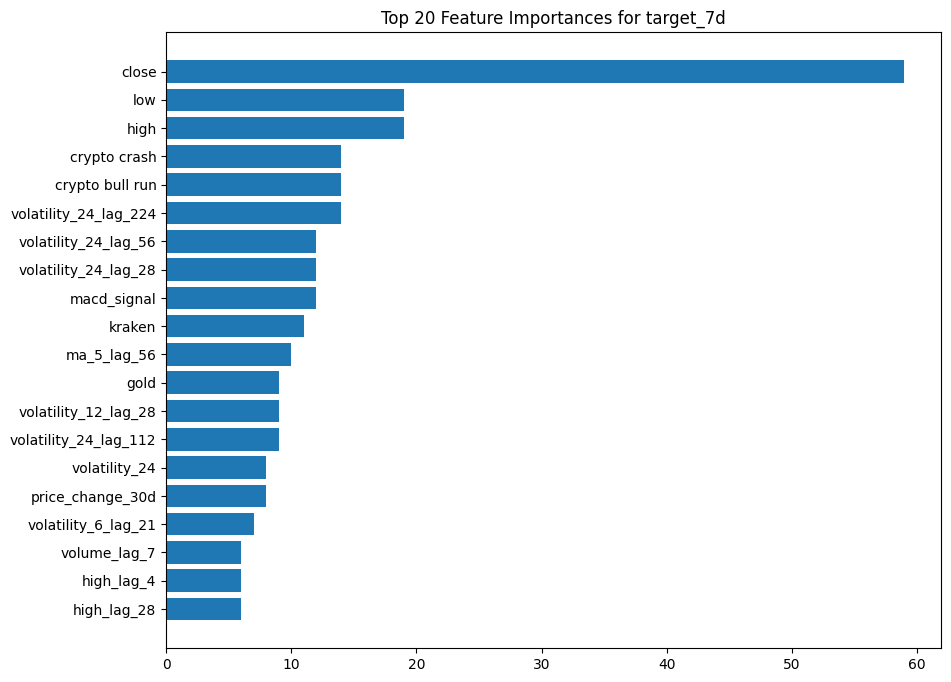

                      feature  importance
18            crypto bull run          25
138              ma_10_lag_28          21
5                     bitcoin          18
20                       gold          16
31                     kraken          15
0                       close          15
139              ma_10_lag_56          14
115            volume_lag_224          14
176             rsi_24_lag_21          13
140             ma_10_lag_112          13
21                        usd          13
141             ma_10_lag_224          12
217      volatility_24_lag_56          12
15               crypto crash          11
218     volatility_24_lag_112          11
258  price_change_30d_lag_224          11
2                         low          11
254   price_change_30d_lag_21          10
1                        high           9
37                      ma_10           8


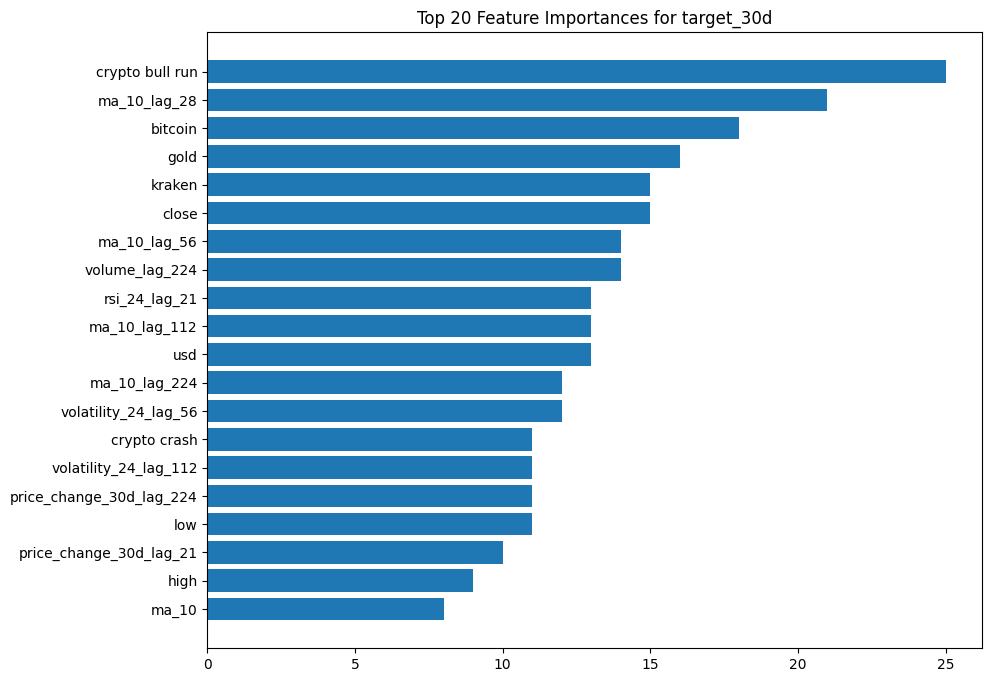

In [47]:
import matplotlib.pyplot as plt

def show_importances(model_: str):
    importances = models[model_].feature_importances_
    features_list = features.columns

    # В DataFrame
    importance_df = pd.DataFrame({'feature': features_list, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Вывод топ-важных признаков
    print(importance_df.head(20))

    # Построить график
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 Feature Importances for {model_}")
    plt.show()

show_importances('target_1d')
show_importances('target_7d')
show_importances('target_30d')
